---
## 2021-02-27
---




# 08-1 합성곱 신경망의 구성 요소

- 합성곱, 필터, 특성 맵, 패딩, 스트라이드, 풀링
- 합성곱 신경망을 구성하는 기본 개념과 동작 원리를 배우고 간단한 합성곱, 풀링 계산 방법을 익힘


## 합성곱

- 입력 데이터에 유용한 특성만 드러나게 하는 것
- 입력 데이터 전체에 가중치를 적용하지 않고 일부에 가중치를 곱함
- 뉴런 = 필터 = 커널
- 특성맵: 합성곱 계산을 통해 얻은 출력


## 케라스 합성곱 층
- Conv2D 클래스로 합성곱 제공

In [1]:
from tensorflow import keras
keras.layers.Conv2D(10, kernel_size=(3, 3), activation='relu')

### 패딩과 스트라이드

- 패딩: 입력 배열의 주위를 가상의 원소로 채우는 것
- 실제 입력값이 아니기 때문에 0으로 채움
- 순전히 커널이 도장을 찍을 횟수를 늘려주는 역할만 함 --> 0이라 계산에 영향 안 미침
- **Same padding**: 입력과 특성 맵의 크기를 동일하게 만들기 위해 입력 주위에 0으로 패딩 하는 것
- **Valid padding**: 패딩 없이 순수한 입력 배열에서만 합성곱을 하여 특성 맵을 만드는 경우

In [2]:
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same')

- 스트라이드(stride): 도장이 한 번에 이동하는 크기 (기본적으로 1)

In [3]:
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same', strides=1)

- stride 매개변수는 잘 사용하지 않음


### 풀링
- 합성곱 층에서 만든 특성 맵의 가로세로 크기를 줄이는 역할을 수행
- 특성맵의 개수는 줄이지 않음
- 풀링에는 가중치가 없음
- 최대 풀링 / 평균 풀링
- 풀링에서는 겹치지 않고 도장이 이동 ((2,2) 풀링이면 가로세로 두 칸씩 이동)

In [4]:
keras.layers.MaxPooling2D(2)

In [5]:
keras.layers.MaxPooling2D(2, strides=2, padding='valid')

## 합성곱 신경망의 전체 구조

- 합성곱 신경망의 입력은 일반적으로 너비와 높이가 있는 이미지


### 컬러 이미지를 사용한 합성곱

- 이미지는 3차원
- 입력이나 필터의 차원이 몇 개인지 상관없이 항상 출력은 하나의 값


## 합성곱 층과 풀링 층 이해하기
- 합성곱 층에서 입력의 크기를 유지하며 각 필터가 추출한 특성 맵을 출력하면 풀링 층에서 특성 맵의 가로세로를 줄임


# 08-2 합성곱 신경망을 사용한 이미지 분류
- Conv2D, MaxPooling2D, plot_model
- 케라스 API를 사용해 합성곱 신경망 모델을 만들어 패션 MNIST 이미지를 분류하는 방법을 배움


## 패션 MNIST 데이터 불러오기
- 합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 일렬로 펼치지 않음

In [6]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

## 합성곱 신경망 만들기

In [7]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                             padding='same', input_shape=(28,28,1)))

In [8]:
model.add(keras.layers.MaxPooling2D(2))

In [9]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu',
                             padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [10]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

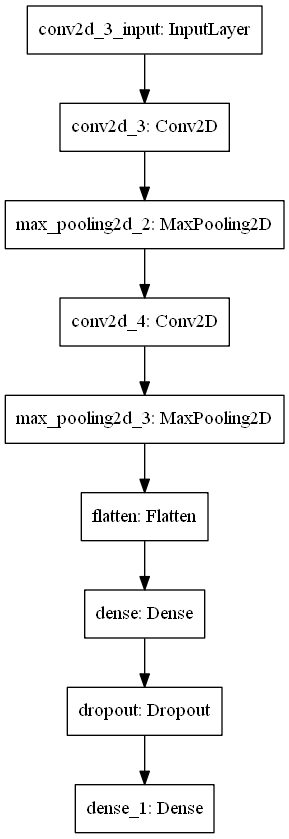

In [12]:
keras.utils.plot_model(model)

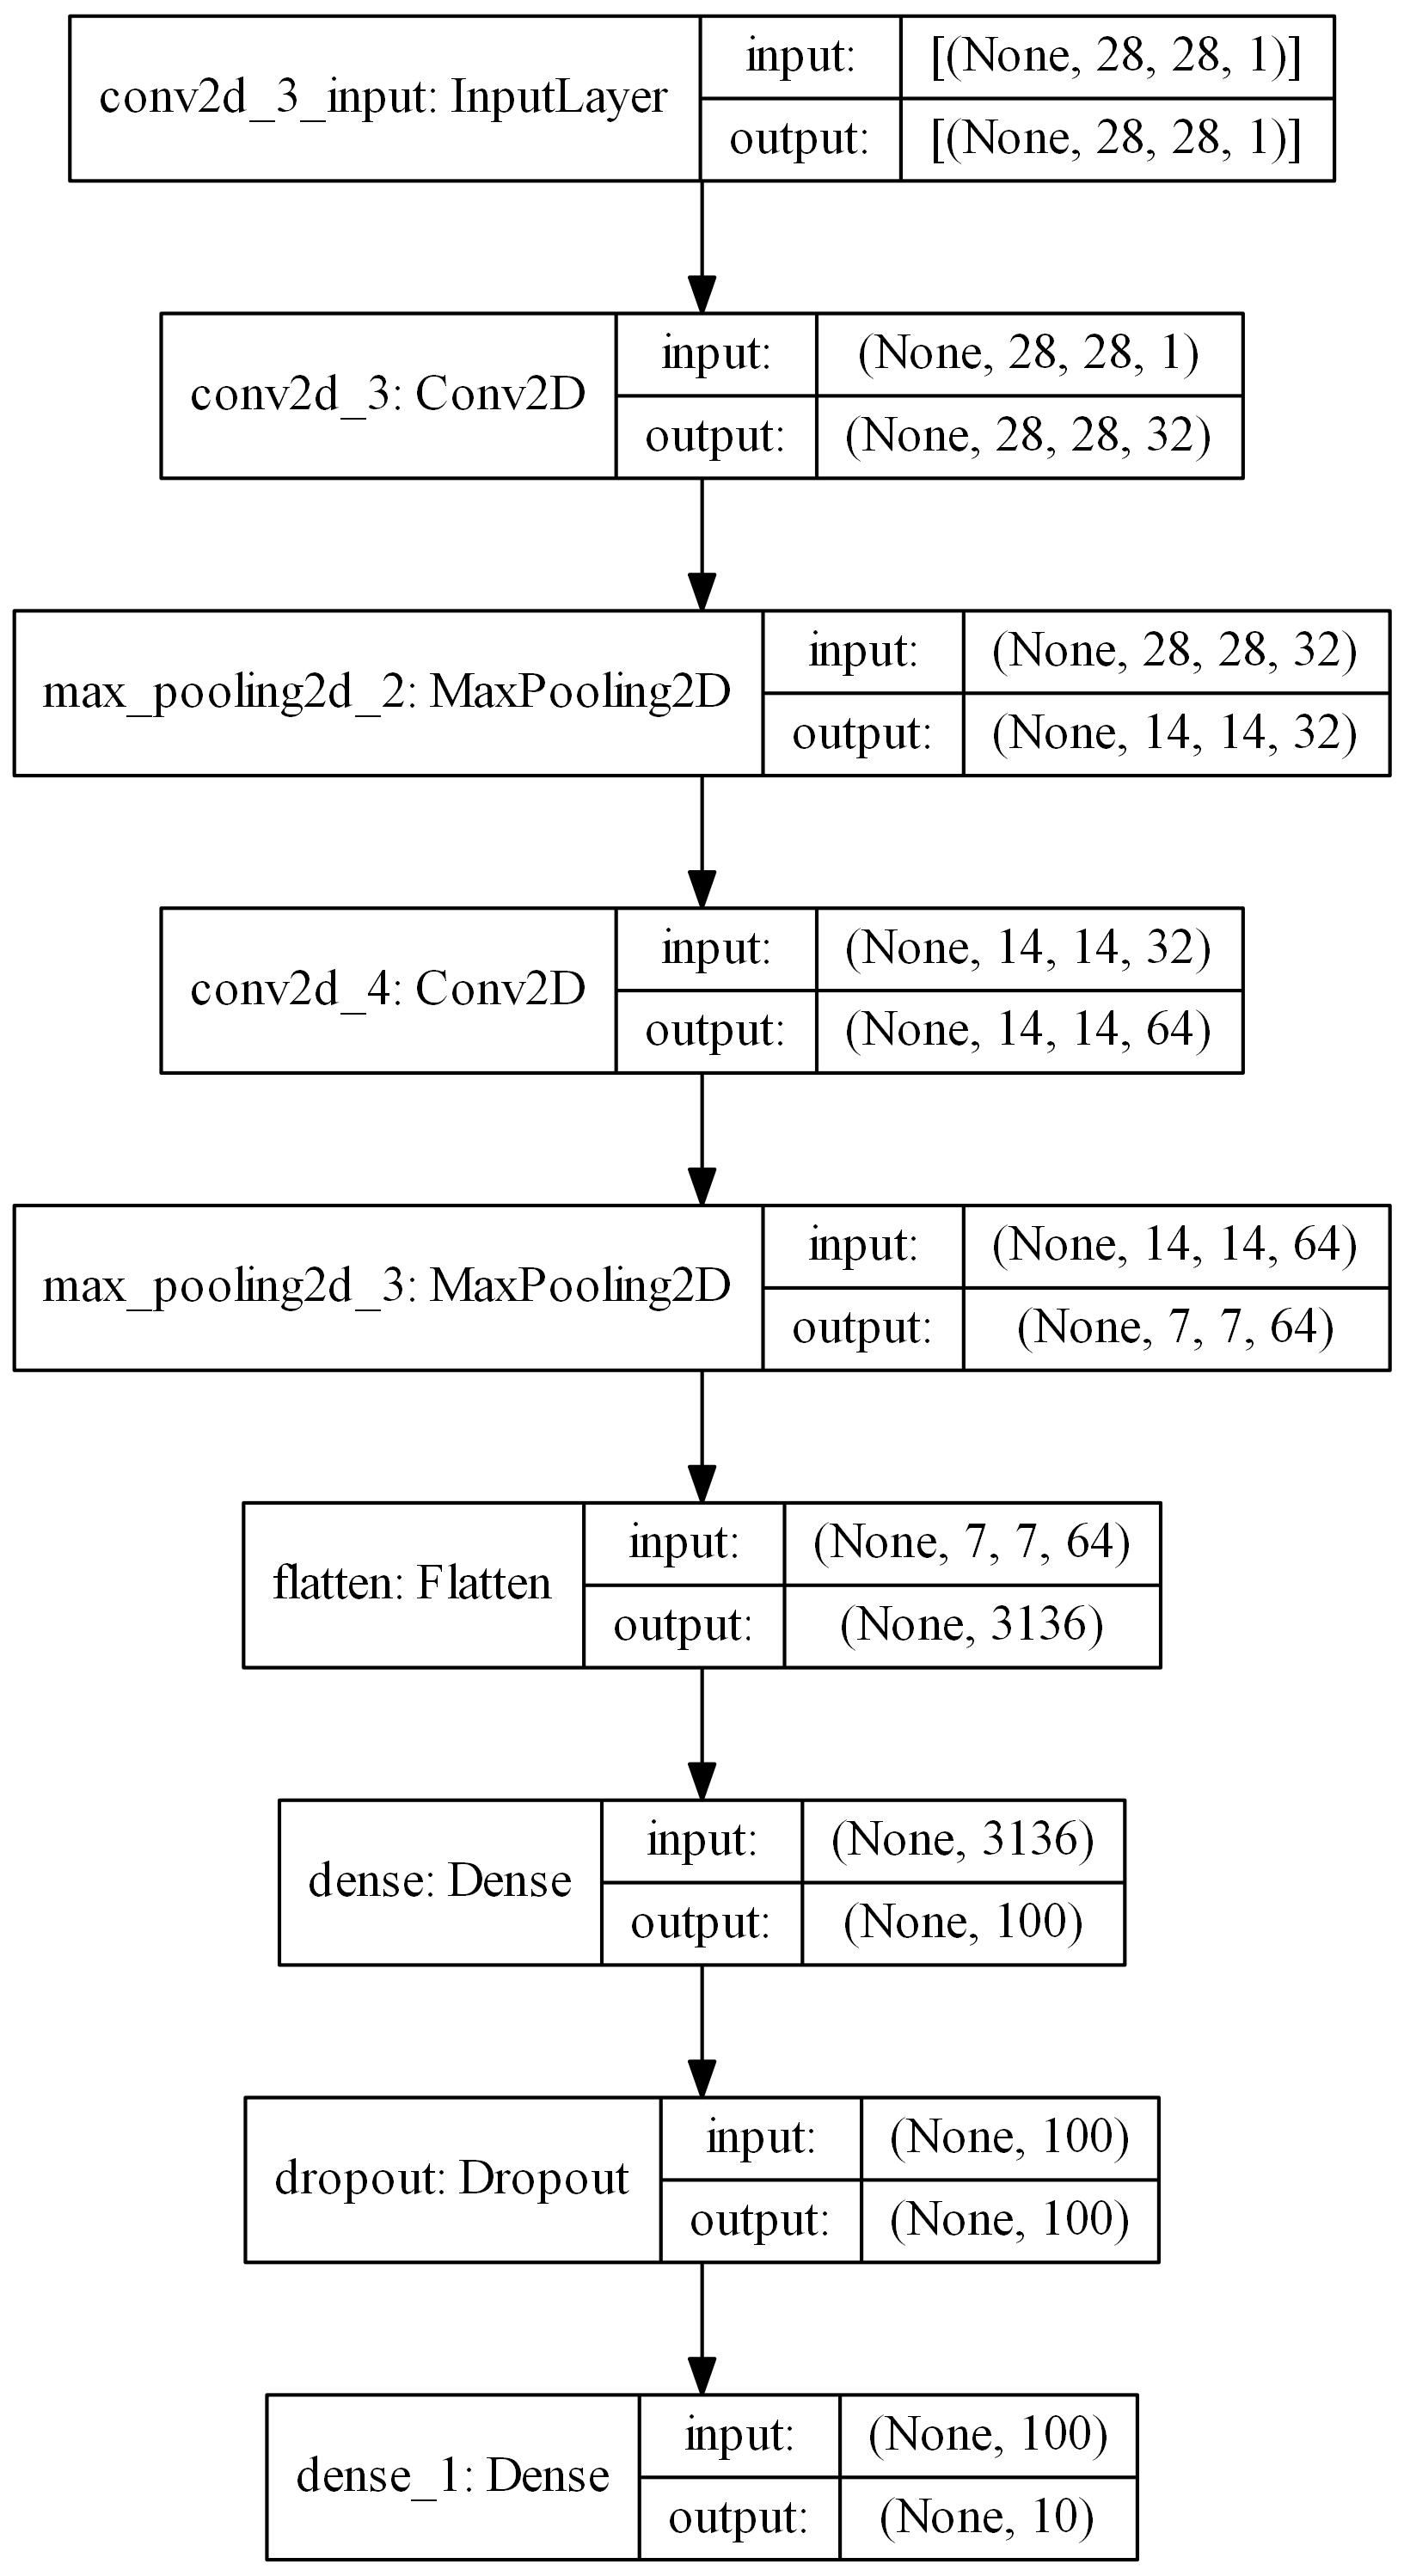

In [13]:
keras.utils.plot_model(model, show_shapes=True,
                      to_file='cnn-architecture.png', dpi=300)

## 모델 컴파일과 훈련

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
             metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                 restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                   validation_data=(val_scaled, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.7152 - accuracy: 0.7442 - val_loss: 0.3372 - val_accuracy: 0.8768
Epoch 2/20
1500/1500 [==============================] - 17s 12ms/step - loss: 0.3627 - accuracy: 0.8706 - val_loss: 0.2829 - val_accuracy: 0.8961
Epoch 3/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.3097 - accuracy: 0.8887 - val_loss: 0.2556 - val_accuracy: 0.9040
Epoch 4/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2688 - accuracy: 0.9014 - val_loss: 0.2435 - val_accuracy: 0.9078
Epoch 5/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2468 - accuracy: 0.9106 - val_loss: 0.2334 - val_accuracy: 0.9154
Epoch 6/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2222 - accuracy: 0.9163 - val_loss: 0.2293 - val_accuracy: 0.9156
Epoch 7/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2073 - accuracy: 0.9231 - val_loss: 0.2260 -

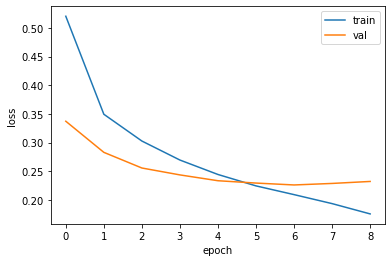

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [16]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2260 - accuracy: 0.9147


[0.22599133849143982, 0.9146666526794434]

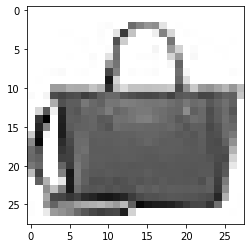

In [17]:
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [18]:
preds = model.predict(val_scaled[0:1])
print(preds)

[[8.0413888e-16 1.3106865e-20 7.0712889e-16 3.6942093e-15 1.2374989e-16
  7.3830475e-17 2.3822315e-16 9.4293056e-18 1.0000000e+00 1.6318300e-19]]


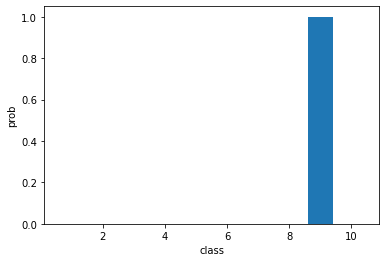

In [19]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob')
plt.show()

In [20]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', 
           '앵클 부츠']

In [22]:
import numpy as np
print(classes[np.argmax(preds)])

가방


In [23]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [24]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2441 - accuracy: 0.9120


[0.24410854279994965, 0.9120000004768372]

## 케라스 API로 합성곱 신경망 구현

- 조기 종료 기법을 사용해 모델을 훈련한 다음 검증 세트로 최적의 에포크에서 성능을 평가함
- 항상 테스트 세트는 모델을 출시하기 직전 딱 한 번만 사용해야 함

# 08-3 합성곱 신경망의 시각화

- 가중치 시각화, 특성 맵 시각화, 함수형 API
- 합성곱 층의 가중치와 특성 맵을 시각화하여 신경망이 이미지에서 어떤 것을 학습하는지 이해


## 가중치 시각화

- 합성곱 층은 여러 개의 필터를 사용해 이미지에서 특징을 학습
- 가중치는 입력 이미지의 2차원 영역에 적용되어 어떤 특징을 크게 두드러지게 표현하는 역할을 함


In [92]:
from tensorflow import keras
model = keras.models.load_model('best-cnn-model.h5')

In [26]:
model.layers

In [27]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [28]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.016727291 0.24249117


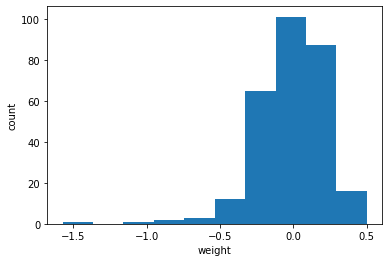

In [29]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

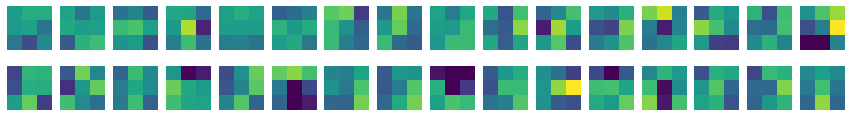

In [30]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')
plt.show()

In [31]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                         padding='same', input_shape=(28,28,1)))

In [32]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [33]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

0.0017467135 0.082088955


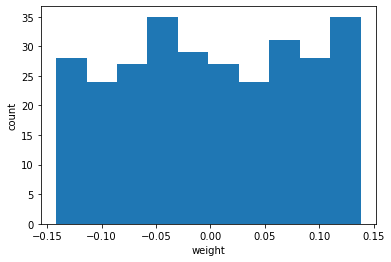

In [34]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

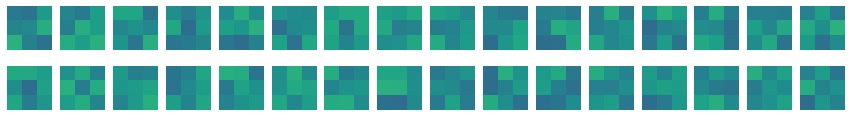

In [35]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5,
                        vmax=0.5)
        axs[i, j].axis('off')
plt.show()

## 함수형 API

- 케라스의 Model 클래스를 사용하여 모델을 만듦

In [36]:
dense1 = keras.layers.Dense(100, activation='sigmoid')
dense2 = keras.layers.Dense(10, activation='softmax')

In [93]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_3_input'), name='conv2d_3_input', description="created by layer 'conv2d_3_input'")


In [94]:
conv_acti = keras.models.Model(model.input, model.layers[0].output)

## 특성 맵 시각화

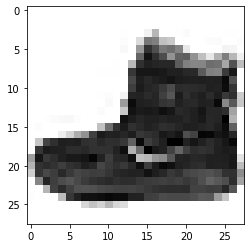

In [95]:
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [96]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

In [97]:
print(feature_maps.shape)

(1, 28, 28, 32)


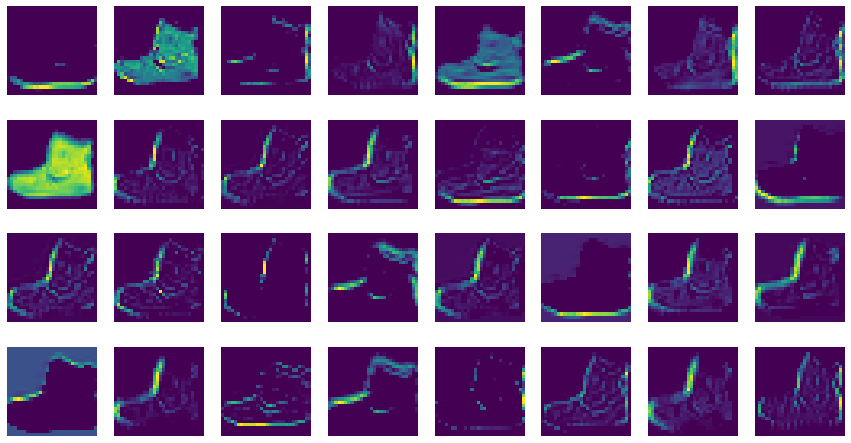

In [98]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')
plt.show()

In [99]:
conv2_acti = keras.models.Model(model.input, model.layers[2].output)

In [100]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

In [101]:
print(feature_maps.shape)

(1, 14, 14, 64)


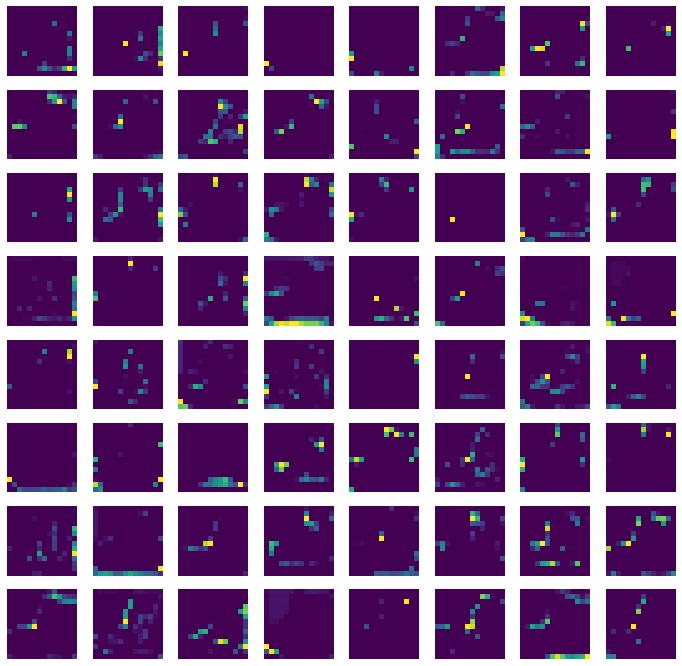

In [102]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')
plt.show()

- 합성곱 신경망의 앞부분에 있는 합성곱 층은 이미지의 시각적인 정보를 감지하고
- 뒤쪽에 있는 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 추상적인 정보를 학습한다고 볼 수 있음


## 시각화로 이해하는 합성곱 신경망

- 입력에 가까운 합성곱 층은 이미지에서 시각적인 정보나 패턴을 감지하도록 훈련
- 이어지는 합성곱 층은 이런 시각적인 정보를 활용해 조금 더 고차원적인 개념을 학습